# Erdos-Renyi Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

import random

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [34]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Directed graph

The first example is a directed graph that represents a social network with three nodes.

In [3]:
G = nx.DiGraph()
G.add_node('Alice')
G.add_node('Bob')
G.add_node('Chuck')
list(G.nodes())

Here's how we add edges between nodes.

In [4]:
G.add_edge('Alice', 'Bob')
G.add_edge('Alice', 'Chuck')
G.add_edge('Bob', 'Alice')
G.add_edge('Bob', 'Chuck')
list(G.edges())

And here's how to draw the graph.

In [5]:
nx.draw_circular(G,
                 node_color='C0',
                 node_size=2000, 
                 with_labels=True)
plt.axis('equal')
savefig('figs/chap02-1')

**Exercise:**  Add another node and a few more edges and draw the graph again.

In [6]:
# Solution goes here

## Undirected graph

The second example is an undirected graph that represents cities and the driving times between them.

`positions` is a dictionary that maps from each city to its coordinates.

In [7]:
positions = dict(Albany=(-74, 43),
                 Boston=(-71, 42),
                 NYC=(-74, 41),
                 Philly=(-75, 40))

positions['Albany']

We can use the keys in `pos` to add nodes to the graph.

In [8]:
G = nx.Graph()
G.add_nodes_from(positions)
G.nodes()

`drive_times` is a dictionary that maps from pairs of cities to the driving times between them.

In [9]:
drive_times = {('Albany', 'Boston'): 3,
               ('Albany', 'NYC'): 4,
               ('Boston', 'NYC'): 4,
               ('NYC', 'Philly'): 2}

We can use the keys from `drive_times` to add edges to the graph.

In [10]:
G.add_edges_from(drive_times)
G.edges()

Now we can draw the graph using `positions` to indicate the positions of the nodes, and `drive_times` to label the edges.

In [11]:
nx.draw(G, positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=2500, 
        with_labels=True)

nx.draw_networkx_edge_labels(G, positions, 
                             edge_labels=drive_times)

plt.axis('equal')
savefig('figs/chap02-2')

**Exercise:**  Add another city and at least one edge.

In [12]:
# Solution goes here

## Complete graph

To make a complete graph, we use a generator function that iterates through all pairs of nodes.

In [13]:
def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

`make_complete_graph` makes a `Graph` with the given number of nodes and edges between all pairs of nodes.

In [9]:
def make_complete_graph(n):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(all_pairs(nodes))
    return G

Here's a complete graph with 10 nodes:

In [15]:
complete = make_complete_graph(10)
complete.number_of_nodes()

And here's what it looks like.

In [16]:
nx.draw_circular(complete, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)
savefig('figs/chap02-3')

The `neighbors` method the neighbors for a given node.

In [17]:
list(complete.neighbors(0))

**Exercise:** Make and draw complete directed graph with 5 nodes.

In [18]:
# Solution goes here

## Random graphs

Next we'll make a random graph where the probability of an edge between each pair of nodes is $p$.

The helper function `flip` returns True with probability `p` and False with probability `1-p`

In [19]:
def flip(p):
    return np.random.random() < p

`random_pairs` is a generator function that enumerates all possible pairs of nodes and yields each one with probability `p` 

In [20]:
def random_pairs(nodes, p):
    for edge in all_pairs(nodes):
        if flip(p):
            yield edge

`make_random_graph` makes an ER graph where the probability of an edge between each pair of nodes is `p`.

In [21]:
def make_random_graph(n, p):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_pairs(nodes, p))
    return G

Here's an example with `n=10` and `p=0.3`

In [22]:
np.random.seed(10)

random_graph = make_random_graph(10, 0.3)
len(random_graph.edges())

And here's what it looks like:

In [23]:
nx.draw_circular(random_graph, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)
savefig('figs/chap02-4')

## Connectivity

To check whether a graph is connected, we'll start by finding all nodes that can be reached, starting with a given node:

In [46]:
def reachable_nodes(G, start):
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(G.neighbors(node))
    return seen

In the complete graph, starting from node 0, we can reach all nodes:

In [25]:
reachable_nodes(complete, 0)

In the random graph we generated, we can also reach all nodes (but that's not always true):

In [26]:
reachable_nodes(random_graph, 0)

We can use `reachable_nodes` to check whether a graph is connected:

In [45]:
def is_connected(G):
    start = next(iter(G))
    reachable = reachable_nodes(G, start)
    return len(reachable) == len(G)

Again, the complete graph is connected:

In [28]:
is_connected(complete)

But if we generate a random graph with a low value of `p`, it's not:

In [29]:
random_graph = make_random_graph(10, 0.1)
len(random_graph.edges())

In [30]:
is_connected(random_graph)

**Exercise:** What do you think it means for a directed graph to be connected?  Write a function that checks whether a directed graph is connected.

In [31]:
# Solution goes here

## Probability of connectivity

Now let's estimare the probability that a randomly-generated ER graph is connected.

This function takes `n` and `p`, generates `iters` graphs, and returns the fraction of them that are connected.

In [32]:
# version with a for loop

def prob_connected(n, p, iters=100):
    count = 0
    for i in range(iters):
        random_graph = make_random_graph(n, p)
        if is_connected(random_graph):
            count += 1
    return count/iters

In [33]:
# version with a list comprehension

def prob_connected(n, p, iters=100):
    tf = [is_connected(make_random_graph(n, p))
          for i in range(iters)]
    return np.mean(tf)

With `n=10` and `p=0.23`, the probability of being connected is about 33%.

In [34]:
np.random.seed(17)

n = 10
prob_connected(n, 0.23, iters=10000)

According to Erdos and Renyi, the critical value of `p` for `n=10` is about 0.23. 

In [35]:
pstar = np.log(n) / n
pstar

So let's plot the probability of connectivity for a range of values for `p`

In [36]:
ps = np.logspace(-1.3, 0, 11)
ps

I'll estimate the probabilities with `iters=1000`

In [37]:
ys = [prob_connected(n, p, 1000) for p in ps]

for p, y in zip(ps, ys):
    print(p, y)

And then plot them, adding a vertical line at the computed critical value

In [38]:
plt.axvline(pstar, color='gray')
plt.plot(ps, ys, color='green')
decorate(xlabel='Prob of edge (p)',
                 ylabel='Prob connected',
                 xscale='log')

savefig('figs/chap02-5')

We can run the same analysis for a few more values of `n`.

In [39]:
ns = [300, 100, 30]
ps = np.logspace(-2.5, 0, 11)

sns.set_palette('Blues_r', 4)
for n in ns:
    print(n)
    pstar = np.log(n) / n
    plt.axvline(pstar, color='gray', alpha=0.3)

    ys = [prob_connected(n, p) for p in ps]
    plt.plot(ps, ys, label='n=%d' % n)

decorate(xlabel='Prob of edge (p)',
         ylabel='Prob connected',
         xscale='log', 
         xlim=[ps[0], ps[-1]],
         loc='upper left')

savefig('figs/chap02-6')

As `n` increases, the critical value gets smaller and the transition gets more abrupt.

## Exercises

**Exercise:** In Chapter 2 we analyzed the performance of `reachable_nodes` and classified it in $O(n + m)$, where $n$ is the number of nodes and $m$ is the number of edges.  Continuing the
analysis, what is the order of growth for `is_connected`?

    def is_connected(G):
        start = list(G)[0]
        reachable = reachable_nodes(G, start)
        return len(reachable) == len(G)

In [40]:
# Solution goes here
# 𝑂(𝑛+𝑚)

**Exercise:** In my implementation of `reachable_nodes`, you might be bothered by the apparent inefficiency of adding *all* neighbors to the stack without checking whether they are already in `seen`.  Write a version of this function that checks the neighbors before adding them to the stack.  Does this "optimization" change the order of growth?  Does it make the function faster?

In [8]:
# test set.union()
s1 = set(range(5))
s2 = set(range(3,7))
s1 | s2

{0, 1, 2, 3, 4, 5, 6}

In [22]:
def reachable_nodes_precheck(G, start):
    seen = set()
    stack = (start)
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack = stack.union(G.neighbors(node))
    return seen
complete = make_complete_graph(100)

In [23]:
%timeit len(reachable_nodes(complete, 0))

952 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit len(reachable_nodes_precheck(complete, 0))

277 ns ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [42]:
# Solution goes here

In [25]:
%timeit len(reachable_nodes(complete, 0))

975 µs ± 42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
%timeit len(reachable_nodes_precheck(complete, 0))

277 ns ± 7.97 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


**Exercise:** There are actually two kinds of ER graphs.  The one we generated in the chapter, $G(n, p)$, is characterized by two parameters, the number of nodes and the probability of an edge between nodes.

An alternative definition, denoted $G(n, m)$, is also characterized by two parameters: the number of nodes, $n$, and the number of edges, $m$.  Under this definition, the number of edges is fixed, but their location is random.

Repeat the experiments we did in this chapter using this alternative definition.  Here are a few suggestions for how to proceed:

1. Write a function called `m_pairs` that takes a list of nodes and the number of edges, $m$, and returns a random selection of $m$ edges.  A simple way to do that is to generate a list of all possible edges and use `random.sample`.

2. Write a function called `make_m_graph` that takes $n$ and $m$ and returns a random graph with $n$ nodes and $m$ edges.

3. Make a version of `prob_connected` that uses `make_m_graph` instead of `make_random_graph`.

4. Compute the probability of connectivity for a range of values of $m$.

How do the results of this experiment compare to the results using the first type of ER graph?

In [30]:
# Solution goes here
def m_pairs(nodes, m):
    all_edges = []
    for edge in all_pairs(nodes):
        all_edges.append(edge)
    return random.sample(all_edges,m)

m_pairs(range(10),5)

[(0, 5), (7, 9), (0, 3), (0, 4), (4, 6)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


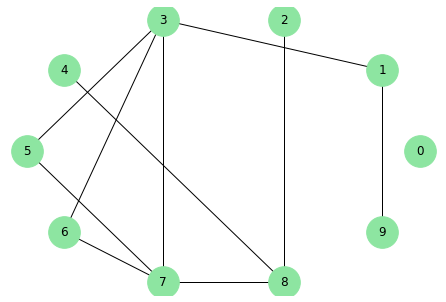

In [42]:
# Solution goes here
def make_m_graph(n,m):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(m_pairs(nodes,m))
    return G

m_graph = make_m_graph(10,10)

nx.draw_circular(m_graph,
                node_color = colors[2],
                node_size = 1000,
                with_labels = True)

In [43]:
# Solution goes here

def prob_connected_m(n,m,iters=100):
    tf = [is_connected(make_m_graph(n,m)) 
          for i in range(iters)]
    return np.mean(tf)

In [59]:
n = 10
pstar = np.log(n) / n
ps = np.logspace(-1.3, 0, 11)
ms = [int(p * n * (n-1) / 2) for p in ps]
ys = [prob_connected_m(n, m, 100) for m in ms]

for p, m, y in zip(ps, ms, ys):
    print(p, m, y)

0.05011872336272722 2 0.0
0.06760829753919818 3 0.0
0.09120108393559097 4 0.0
0.12302687708123815 5 0.0
0.16595869074375605 7 0.0
0.22387211385683395 10 0.28
0.3019951720402016 13 0.63
0.40738027780411273 18 0.96
0.5495408738576245 24 0.99
0.7413102413009173 33 1.0
1.0 45 1.0


In [61]:
for m in range(25):
    print(m,round(prob_connected_m(10,m),4))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.12
10 0.31
11 0.39
12 0.56
13 0.67
14 0.74
15 0.9
16 0.91
17 0.89
18 0.95
19 0.96
20 0.97
21 0.98
22 0.98
23 1.0
24 1.0
